<h1><center>Lab 5 </center></h1>

## **WORK DURING THE LAB**
1. Implement an evolutionary algorithm for the knapsack problem. 
    - Population initialization for binary codification 
    - Crossover operator 
    - Mutation operator 
    - Fitness function 
2. Test the algorithm for the two problem instances (size 20 and 200), considering different 
parameter settings. 

## Knapsack Problem
- $n$ objects, each has a value ($v$) and a weight ($w$)
- Objective: the knapsack to contain max value without exceeding max weight $W$
 - $x_i=1$ means object $i$ is selected
 - $x_i=0$ means object $j$ is not selected

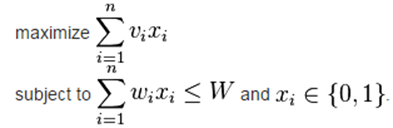


### General functions for Knapsack Problem

In [1]:
from pickle import POP_MARK

import numpy as np

def load_data(file_name: str) -> "list[tuple[int, int]], int, int":
    weights_and_values = []
    with open(file_name) as f:
        lines = f.readlines()
        num_items = int(lines[0].strip())
        for line in lines[1:num_items + 1]:
            parts = line.split()
            weight, value = int(parts[1]), int(parts[2])
            weights_and_values.append((weight, value))
        capacity = int(lines[num_items + 1].strip())
    return weights_and_values, capacity, num_items

def generate_solution(n: int):
    """
        Generate solution of length n using binary encoding
        Input:
          n: int
        Output:
          sol: list
              - binary encoding solution
    """
    return np.random.randint(2, size=n).tolist()

def fitness(solution: list[int], data: list[tuple[int, int]], capacity: int) -> tuple[int, int]:
    """
    Fitness function to evaluate the solution for the knapsack problem by calculating the total weight and value of the solution
    Input:
        solution: list of 0s and 1s representing the inclusion of items
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        total weight, total value of solution
    """
    total_value = 0
    total_weight = 0
    
    for i in range(len(solution)):
        if solution[i] == 1:
            total_value += data[i][1]
            total_weight+= data[i][0]
    
    return total_weight, total_value

def is_valid(solution: list[int], data: list[tuple[int, int]], capacity: int) -> bool:
    """
    Check if the solution is valid by checking if the total weight of the solution is less than the capacity
    Input:
        solution: list of 0s and 1s representing the inclusion of items
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        bool: True if the solution is valid, False otherwise
    """
    weight = fitness(solution, data, capacity)[0]
    
    return weight <= capacity

def generate_valid_sol(data: list[tuple[int, int]], capacity: int) -> list[int]:
    """
    Generate a valid solution by generating random solutions until a valid solution is found
    Input:
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        list: a valid solution
    """
    while True:
        solution = generate_solution(len(data))
        if is_valid(solution, data, capacity):
            return solution

### Pseudocode for evolutionary algorithm:
     BEGIN
        INITIALIZE population with random candidate solutions;
        EVALUATE each candidate;
        REPEAT
          1) SELECT parents;
          2) RECOMBINE pairs of parents;
          3) MUTATE the resulting offspring;
          4) EVALUATE new candidates;
          5) SELECT individuals for next generation;
        UNTIL (terminations condition) is satisfied
     END

In [2]:
# Generate population
def generate_population(pop_size: int, data: list[tuple[int, int]], capacity: int) -> "list[list[int]]":
    """
    Generate population of size pop_size
    Input:
        pop_size: int, size of the population
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        list: a population of size pop_size
    """
    population = []
    for i in range(pop_size):
        population.append(generate_valid_sol(data, capacity))
    return population

def repair_solution(solution: list[int], data: list[tuple[int, int]], capacity: int) -> list[int]:
    """
    Repair a solution by removing items until it is within the capacity limit.
    Input:
        solution: list of 0s and 1s representing the items in the knapsack
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        list: repaired solution
    """
    # Calculate the total weight of the current solution
    total_weight = sum(weight for (weight, _), selected in zip(data, solution) if selected)
    
    # Remove items randomly until the total weight is within the capacity
    while total_weight > capacity:
        selected_indices = [i for i, selected in enumerate(solution) if selected]
        
        item_index = np.random.choice(selected_indices)
        
        # Remove the random selected item
        solution[item_index] = 0

        total_weight -= data[item_index][0]
        
    return solution

def crossover(parent1: list[int], parent2: list[int], crossover_rate: float, data: list[tuple[int, int]], capacity: int) -> tuple[list[int], list[int]]:
    """
    Perform single-point crossover between two parents with a given crossover rate and validate the offsprings.
    Input:
        parent1: list of 0s and 1s
        parent2: list of 0s and 1s
        crossover_rate: float, probability of performing crossover
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
    Output:
        tuple: two offsprings resulting from the crossover
    """
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, len(parent1) - 1)
        offspring1 = parent1[:point] + parent2[point:]
        offspring2 = parent2[:point] + parent1[point:]
    else:
        # If crossover is not performed, return the parents as offsprings
        offspring1 = parent1
        offspring2 = parent2

    # Validate and repair the offsprings if necessary
    if not is_valid(offspring1, data, capacity):
        offspring1 = repair_solution(offspring1, data, capacity)
    if not is_valid(offspring2, data, capacity):
        offspring2 = repair_solution(offspring2, data, capacity)

    return offspring1, offspring2

import random
def select_tournament(population: list[list[int]], data: list[tuple[int, int]], capacity: int) -> list[int]:
    """
    Selects the best individual out of 3 randomly selected individuals from the population.
    Input:
        population: list of individuals (each individual is a list of 0s and 1s)
        data: list of tuples, each containing the weight and value of an item
        capacity: int, the maximum capacity of the knapsack
    Output:
        list: the selected individual
    """
    selected = random.sample(population, 3)
    best_individual = max(selected, key=lambda ind: fitness(ind, data, capacity)[1])
    return best_individual
    
def mutate(solution: list[int], mutation_rate: float) -> list[int]:
    """
    Perform mutation on a solution with a given mutation rate.
    Input:
        solution: list of 0s and 1s
        mutation_rate: float, probability of performing mutation
    Output:
        list: mutated solution
    """
    for i in range(len(solution)):
        if np.random.rand() < mutation_rate:
            solution_check = solution.copy()
            solution_check[i] = 1 - solution_check[i]
            if is_valid(solution_check, data, capacity):
                solution[i] = 1 - solution[i]
    
    return solution
            

def replace(population: list[list[int]], offsprings: list[list[int]]) -> list[list[int]]:
    """
    Replace the worst individuals in the population with the offsprings.
    Input:
        population: list of individuals (each individual is a list of 0s and 1s)
        offsprings: list of offsprings
    Output:
        list: new population
    """
    new_pop = population + offsprings
    new_pop = sorted(new_pop, key=lambda sol: fitness(sol, data, capacity)[1], reverse=True)
    population = new_pop[:len(population)]

    return population
    


In [3]:

def evolutionary_algorithm(data: list[tuple[int, int]], capacity: int, pop_size: int, crossover_rate: float, mutation_rate: float, generations: int) -> tuple[list[int], int]:
    """
    Perform an evolutionary algorithm to solve the knapsack problem.
    Input:
        data: list of tuples where each tuple contains (weight, value) of an item
        capacity: int, maximum capacity of the knapsack
        pop_size: int, size of the population
        crossover_rate: float, probability of performing crossover
        mutation_rate: float, probability of performing mutation
        generations: int, number of generations to run the algorithm
    Output:
        tuple: best solution found and its fitness value
    """
    # Generate initial population
    population = generate_population(pop_size, data, capacity)

    for generation in range(generations):
        # Sort population based on fitness
        population = sorted(population, key=lambda sol: fitness(sol, data, capacity)[1], reverse=True)
        prime_population = [select_tournament(population, data, capacity) for _ in range(pop_size)]
        
        offsprings = []

        # Generate new population
        for i in range(0, pop_size, 2):
            parent1, parent2 = prime_population[i], prime_population[min(i + 1, pop_size - 1)]
            offspring1, offspring2 = crossover(parent1, parent2, crossover_rate, data, capacity)
            
            offsprings.append(mutate(offspring1, mutation_rate))
            offsprings.append(mutate(offspring2, mutation_rate))

        population = replace(population, offsprings)

    # Find the best solution in the final population
    best_solution = max(population, key=lambda sol: fitness(sol, data, capacity)[1])

    return best_solution, fitness(best_solution, data, capacity)[1]

### Testing with different parameters

In [4]:
data, capacity, num_items = load_data("data/knapsack/knapsack-20.txt")

pop_size = 100
crossover_rate = 0.7
mutation_rate = 0.01
generations = 150

sol, val = evolutionary_algorithm(data, capacity, pop_size, crossover_rate, mutation_rate, generations)
print("Best value found:", val)

Best value found: 762


In [5]:
data, capacity, num_items = load_data("data/knapsack/rucsac-200.txt")

pop_size = 100
crossover_rate = 0.7
mutation_rate = 0.01
generations = 1000

sol, val = evolutionary_algorithm(data, capacity, pop_size, crossover_rate, mutation_rate, generations)
print("Best value found:", val)

sol, val = evolutionary_algorithm(data, capacity, 500, 0.8, 0.001, 1000)
print("Best value found:", val)



Best value found: 99945


KeyboardInterrupt: 

# **ASSIGNMENT A5**
1. Implement an evolutionary algorithm for TSP.
2. Perform experiments for the two TSP instances selected in the previous lab and compare
results, considering different parameter settings for the algorithm.
3. Compare at least 2 different crossover operators.

### General functions for TSP

In [6]:
import numpy as np

def load_tsp_data(file_name: str) -> list[tuple[float, float]]:
    """
    Load TSP data from file
    Input:
        file_name: str, name of the file containing TSP data
    Output:
        list of tuples: each tuple contains (x, y) coordinates of a city
    """
    with open(file_name) as f:
        lines = f.readlines()
        data = []
        start_reading = False
        for line in lines:
            if line.strip() == "NODE_COORD_SECTION":
                start_reading = True
                continue
            if start_reading:
                if line.strip() == "EOF":
                    break
                parts = line.split()
                data.append((float(parts[1]), float(parts[2])))
    return data

def euclidean_distance(city1: tuple[float, float], city2: tuple[float, float]) -> float:
    """
    Calculate the Euclidean distance between two cities
    Input:
        city1: tuple, (x, y) coordinates of city 1
        city2: tuple, (x, y) coordinates of city 2
    Output:
        float: Euclidean distance between the two cities
    """
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def random_tour(cities: list[tuple[float, float]]) -> list[int]:
    """
    Generate random tours by shuffling the cities
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        list: list of random tours
    """
    n = len(cities)
    tour = np.random.permutation(n).tolist()
    return tour


def fitness_tsp(tour: list[int], cities: list[tuple[float, float]]) -> float:
    """
    Calculate the total distance of the tour.
    Input:
        tour: list of city indices representing the tour
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        float: total distance of the tour
    """
    total_distance = 0.0
    n = len(tour)
    for i in range(n):
        total_distance += euclidean_distance(cities[tour[i]], cities[tour[(i + 1) % n]])  # Wrap around

    # Return distance rounded for better readability
    return round(total_distance, 2)



## Evolutionary Algorithm for TSP

In [9]:
import random

def pmx_crossover(parent1: list[int], parent2: list[int]) -> tuple[list[int], list[int]]:
    """
    Perform partially mapped crossover (PMX) between two parents.
    Input:
        parent1: list of city indices representing the first parent
        parent2: list of city indices representing the second parent
    Output:
        tuple: two offsprings resulting from the crossover
    """
    length = len(parent1)
    offspring1, offspring2 = [-1] * length, [-1] * length

    # Randomly select two crossover points
    point1, point2 = sorted(random.sample(range(length), 2))

    point1, point2 = 3, 7


    # Copy the segment from parent1 to offspring1 and parent2 to offspring2
    offspring1[point1:point2] = parent1[point1:point2]
    offspring2[point1:point2] = parent2[point1:point2]

    # Create mappings for the crossover segments
    mapping1 = {parent1[i]: parent2[i] for i in range(point1, point2)}
    mapping2 = {parent2[i]: parent1[i] for i in range(point1, point2)}

    # Fill the remaining positions in offspring1
    for i in range(length):
        if offspring1[i] == -1:
            value_to_place = parent2[i]
            while value_to_place in mapping1:
                value_to_place = mapping1[value_to_place]
            offspring1[i] = value_to_place

    # Fill the remaining positions in offspring2
    for i in range(length):
        if offspring2[i] == -1:
            value_to_place = parent1[i]
            while value_to_place in mapping2:
                value_to_place = mapping2[value_to_place]
            offspring2[i] = value_to_place

    return offspring2, offspring1



def cycle_crossover(parent1: list[int], parent2: list[int]) -> tuple[list[int], list[int]]:
    """
    Perform cycle crossover between two parents.
    Input:
        parent1: list of city indices representing the first parent
        parent2: list of city indices representing the second parent
    Output:
        tuple: two offsprings resulting from the crossover
    """
    length = len(parent1)
    offspring1, offspring2 = [-1] * length, [-1] * length

    # Step 1: Find the cycle
    visited = [False] * length
    cycle = []

    # Start with the first index
    index = 0
    while not visited[index]:
        # Add the value from parent2 at this index to the cycle
        cycle.append(index)
        visited[index] = True
        # Go to the index in parent1 that corresponds to the value at this index in parent2
        index = parent1.index(parent2[index])

    # Step 2: Create the first offspring (offspring1)
    for i in cycle:
        offspring1[i] = parent2[i]

    # Step 3: Fill the remaining positions in offspring1 with values from parent1
    for i in range(length):
        if offspring1[i] == -1:
            offspring1[i] = parent1[i]

    # Step 4: Create the second offspring (offspring2)
    for i in range(length):
        if offspring1[i] == parent1[i]:
            offspring2[i] = parent2[i]
        else:
            offspring2[i] = parent1[i]

    return offspring1, offspring2


def mutate_tsp(tour: list[int], mutation_rate: float) -> list[int]:
    """
    Perform a swap mutation on a tour with a given mutation rate.
    Input:
        tour: list of city indices representing the tour
        mutation_rate: float, probability of performing mutation
    Output:
        list: mutated tour
    """
    if np.random.rand() < mutation_rate:

        n = len(tour)
        i, j = sorted(np.random.choice(n, 2, replace=False))  # Pick two points
        tour[i:j+1] = reversed(tour[i:j+1])  # Reverse the segment
    return tour

def generate_population_tsp(pop_size: int, cities: list[tuple[float, float]]) -> list[list[int]]:
    """
    Generate population of size pop_size
    Input:
        pop_size: int, size of the population
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
    Output:
        list: a population of size pop_size
    """
    population = []
    for i in range(pop_size):
        population.append(random_tour(cities))
    return population

def select_tournament_tsp(population: list[list[int]], cities: list[tuple[float, float]]) -> list[int]:
    """
    Selects the best individual out of 3 randomly selected individuals from the population.
    Input:
        population: list of individuals (each individual is a list of city indices)
        cities: list of tuples, each containing the (x, y) coordinates of a city
    Output:
        list: the selected individual
    """
    selected = random.sample(population, 3)
    best_individual = min(selected, key=lambda ind: fitness_tsp(ind, cities))
    return best_individual

def replace_tsp(population, offsprings, cities):
    """
    Replace the worst individuals but keep the best 10% (elitism).
    """
    elites = sorted(population, key=lambda sol: fitness_tsp(sol, cities))[:max(1, len(population) // 10)]
    new_pop = sorted(population + offsprings, key=lambda sol: fitness_tsp(sol, cities))[:len(population) - len(elites)]
    return elites + new_pop

In [3]:
# Main Evolutionary Algorithm for TSP

def evolutionary_algorithm_tsp(cities: list[tuple[float, float]], pop_size: int, mutation_rate: float, generations: int, crossover_operator: str) -> tuple[list[int], float]:
    """
    Perform an evolutionary algorithm to solve the TSP.
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        pop_size: int, size of the population
        crossover_rate: float, probability of performing crossover
        mutation_rate: float, probability of performing mutation
        generations: int, number of generations to run the algorithm
        crossover_operator: str, the crossover operator to use
    Output:
        tuple: best solution found and its fitness value
    """
    # Generate initial population
    population = generate_population_tsp(pop_size, cities)

    for generation in range(generations):
        # Sort population based on fitness
        population = sorted(population, key=lambda sol: fitness_tsp(sol, cities))
        prime_population = [select_tournament_tsp(population, cities) for _ in range(pop_size)]

        offsprings = []

        # lower mutation rate every 100 generations to avoid local minima
        if generation % 100 == 0 and generation > 0:
            mutation_rate *= 0.95  # Slowly reduce mutation rate
        # Generate new population
        for i in range(0, pop_size, 2):
            parent1, parent2 = prime_population[i], prime_population[min(i + 1, pop_size - 1)]
            if crossover_operator == "pmx":
                offspring1, offspring2 = pmx_crossover(parent1, parent2)
            elif crossover_operator == "cycle":
                offspring1, offspring2 = cycle_crossover(parent1, parent2)
            else:
                raise ValueError("Invalid crossover operator")

            offsprings.append(mutate_tsp(offspring1, mutation_rate))
            offsprings.append(mutate_tsp(offspring2, mutation_rate))

        population = replace_tsp(population, offsprings, cities)

    # Find the best solution in the final population
    best_solution = min(population, key=lambda sol: fitness_tsp(sol, cities))

    return population, fitness_tsp(best_solution, cities)

### Functions for testing purposes

In [459]:
import time
import matplotlib.pyplot as plt

def plot_comparison_pmx_cycle(cities: list[tuple[float, float]], pop_size: int, mutation_rate: float, generations_list: list[int]):
    """
    Plot the comparison between PMX and Cycle crossover for different generations
    """
    pmx_results = []
    cycle_results = []

    print("| Crossover | Generations | Value | Computation Time (s) |")
    print("|-----------|-------------|-------|----------------------|")

    for generations in generations_list:
        start = time.time()
        _, pmx_value = evolutionary_algorithm_tsp(cities, pop_size, mutation_rate, generations, crossover_operator='pmx')
        end = time.time()
        pmx_time = end - start
        print(f"| PMX       | {generations}       | {pmx_value:.2f} | {pmx_time:.2f} |")
        pmx_results.append((generations, pmx_value, pmx_time))

        start = time.time()
        _, cycle_value = evolutionary_algorithm_tsp(cities, pop_size, mutation_rate, generations, crossover_operator='cycle')
        end = time.time()
        cycle_time = end - start
        print(f"| Cycle     | {generations}       | {cycle_value:.2f} | {cycle_time:.2f} |")
        cycle_results.append((generations, cycle_value, cycle_time))

    # Plot the results
    pmx_values = [result[1] for result in pmx_results]
    cycle_values = [result[1] for result in cycle_results]

    plt.figure(figsize=(12, 8))
    plt.plot(generations_list, pmx_values, label='PMX Crossover', marker='o', color='blue')
    plt.plot(generations_list, cycle_values, label='Cycle Crossover', marker='o', color='red')
    plt.xlabel('Generations', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.title('Comparison between PMX and Cycle Crossover', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Testing for `kroA100.tsp`

| Crossover | Generations | Value | Computation Time (s) |
|-----------|-------------|-------|----------------------|
| PMX       | 10       | 128266.50 | 0.52 |
| Cycle     | 10       | 133444.24 | 0.54 |
| PMX       | 50       | 81709.22 | 2.52 |
| Cycle     | 50       | 101787.28 | 2.27 |
| PMX       | 100       | 65489.23 | 4.74 |
| Cycle     | 100       | 76319.13 | 4.91 |
| PMX       | 200       | 47172.71 | 9.64 |
| Cycle     | 200       | 55973.57 | 9.31 |
| PMX       | 300       | 36860.33 | 13.90 |
| Cycle     | 300       | 48744.42 | 14.82 |
| PMX       | 500       | 32677.08 | 24.57 |
| Cycle     | 500       | 32867.08 | 23.36 |
| PMX       | 1000       | 25093.24 | 46.68 |
| Cycle     | 1000       | 26870.07 | 47.54 |
| PMX       | 3000       | 24873.69 | 139.46 |
| Cycle     | 3000       | 25577.20 | 136.72 |


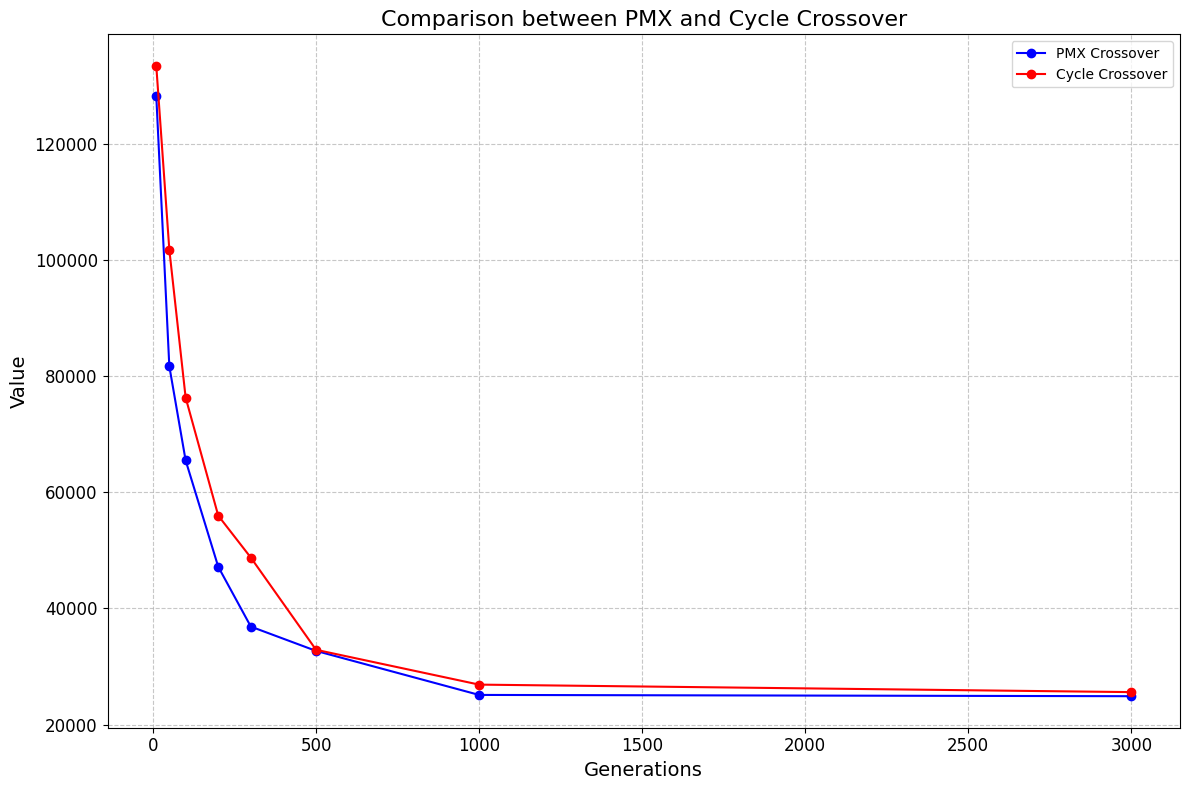

In [480]:
cities = load_tsp_data("data/tsp/kroE100.tsp")
plot_comparison_pmx_cycle(cities, 50, 0.3, [10, 50, 100, 200, 300, 500, 1000, 3000])

| Generations | PMX Value | PMX Time (s) | Cycle Value | Cycle Time (s) |
|-------------|-----------|--------------|-------------|----------------|
| 10          | 128266.50 | 0.52         | 133444.24   | 0.54           |
| 50          | 81709.22  | 2.52         | 101787.28   | 2.27           |
| 100         | 65489.23  | 4.74         | 76319.13    | 4.91           |
| 200         | 47172.71  | 9.64         | 55973.57    | 9.31           |
| 300         | 36860.33  | 13.90        | 48744.42    | 14.82          |
| 500         | 32677.08  | 24.57        | 32867.08    | 23.36          |
| 1000        | 25093.24  | 46.68        | 26870.07    | 47.54          |
| 3000        | 24873.69  | 139.46       | 25577.20    | 136.72         |

# Results and conclusions for `kroE100.tsp` dataset
## Plot:
   - The algorithm gets better as the number of generations increases.
   - The convergence gets slower after 1000+ generations.
   - The PMX crossover method outperforms the Cycle crossover method.
## Table:
   - Computation Times are the same for both methods.
   - The computation time grows linearly with the number of generations.


In [473]:

def plot_comparison_pmx_cycle_diff_mutation(cities: list[tuple[float, float]], generations: int, mutation_rates: list[float], pop_sizes: list[int]):
    """
    Plot the comparison between PMX and Cycle crossover for the same number of generations with different mutation rates
    and different population sizes.
    """
    pmx_results = {pop_size: [] for pop_size in pop_sizes}
    cycle_results = {pop_size: [] for pop_size in pop_sizes}

    print("| Crossover | Population Size | Mutation Rate | Value | Computation Time (s) |")
    print("|-----------|-----------------|---------------|-------|----------------------|")

    for pop_size in pop_sizes:
        for mutation_rate in mutation_rates:
            start = time.time()
            _, pmx_value = evolutionary_algorithm_tsp(cities, pop_size, mutation_rate, generations, 'pmx')
            end = time.time()
            pmx_time = end - start
            pmx_results[pop_size].append((mutation_rate, pmx_value, pmx_time))
            print(f"| PMX       | {pop_size}           | {mutation_rate}         | {pmx_value} | {pmx_time:.2f} |")

            start = time.time()
            _, cycle_value = evolutionary_algorithm_tsp(cities, pop_size, mutation_rate, generations, 'cycle')
            end = time.time()
            cycle_time = end - start
            cycle_results[pop_size].append((mutation_rate, cycle_value, cycle_time))
            print(f"| Cycle     | {pop_size}           | {mutation_rate}         | {cycle_value} | {cycle_time:.2f} |")

    # Plot the results
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    for pop_size in pop_sizes:
        pmx_values = [result[1] for result in pmx_results[pop_size]]
        cycle_values = [result[1] for result in cycle_results[pop_size]]
        axs[0].plot(mutation_rates, pmx_values, label=f'Population {pop_size}', marker='o')
        axs[1].plot(mutation_rates, cycle_values, label=f'Population {pop_size}', marker='o')

    axs[0].set_xlabel('Mutation Rate', fontsize=14)
    axs[0].set_ylabel('Value', fontsize=14)
    axs[0].set_title(f'PMX Crossover with {generations} Generations', fontsize=16)
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].tick_params(axis='both', which='major', labelsize=12)

    axs[1].set_xlabel('Mutation Rate', fontsize=14)
    axs[1].set_ylabel('Value', fontsize=14)
    axs[1].set_title(f'Cycle Crossover with {generations} Generations', fontsize=16)
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.show()

| Crossover | Population Size | Mutation Rate | Value | Computation Time (s) |
|-----------|-----------------|---------------|-------|----------------------|
| PMX       | 5           | 0         | 167507.5 | 0.47 |
| Cycle     | 5           | 0         | 157783.3 | 0.47 |
| PMX       | 5           | 0.25         | 115272.06 | 0.48 |
| Cycle     | 5           | 0.25         | 114600.45 | 0.49 |
| PMX       | 5           | 0.5         | 99283.09 | 0.47 |
| Cycle     | 5           | 0.5         | 97029.31 | 0.46 |
| PMX       | 5           | 0.75         | 85600.97 | 0.46 |
| Cycle     | 5           | 0.75         | 91519.59 | 0.47 |
| PMX       | 5           | 1         | 85031.84 | 0.49 |
| Cycle     | 5           | 1         | 87616.24 | 0.47 |
| PMX       | 15           | 0         | 148546.71 | 1.33 |
| Cycle     | 15           | 0         | 155282.81 | 1.33 |
| PMX       | 15           | 0.25         | 88268.18 | 1.37 |
| Cycle     | 15           | 0.25         | 99806.38 | 1.70 |


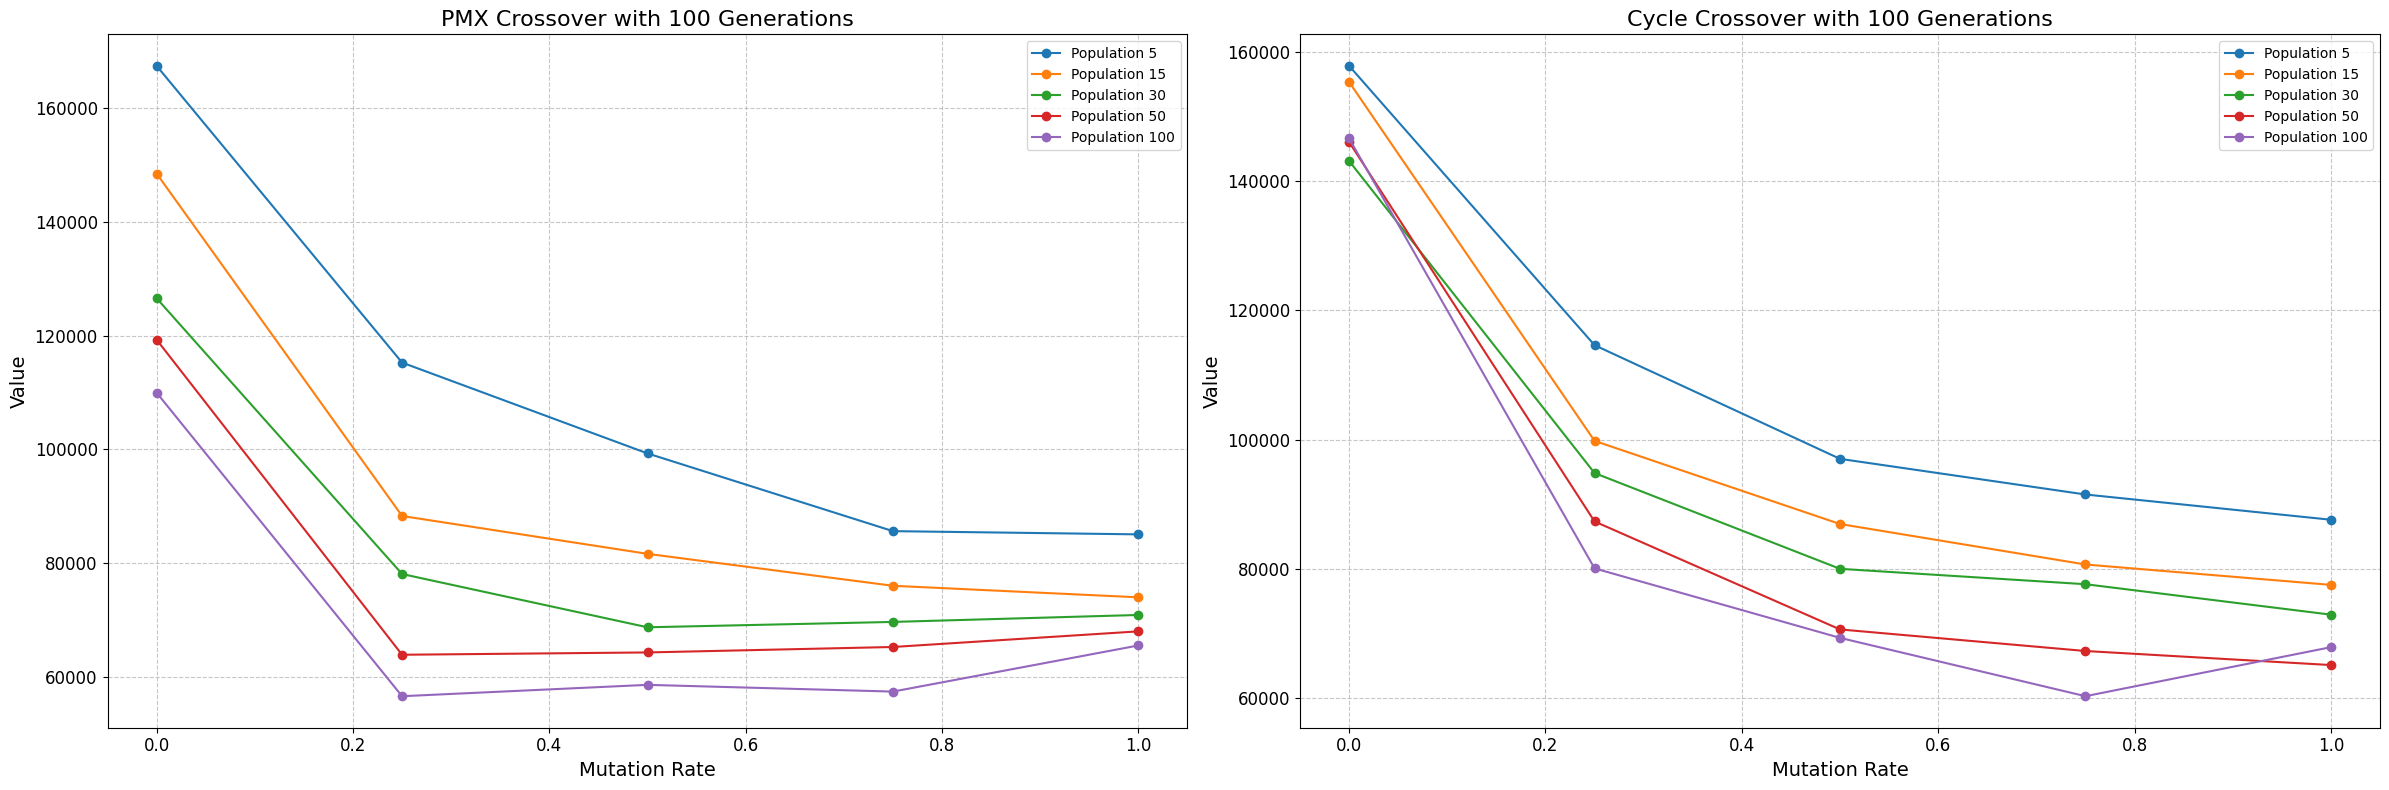

In [479]:
plot_comparison_pmx_cycle_diff_mutation(cities, 100, [0, 0.25, 0.5, 0.75, 1], [5, 15, 30, 50, 100])

| Population Size | Mutation Rate | PMX Value | PMX Time (s) | Cycle Value | Cycle Time (s) |
|-----------------|---------------|-----------|--------------|-------------|----------------|
| 5               | 0             | 167507.5  | 0.47         | 157783.3    | 0.47           |
| 5               | 0.25          | 115272.06 | 0.48         | 114600.45   | 0.49           |
| 5               | 0.5           | 99283.09  | 0.47         | 97029.31    | 0.46           |
| 5               | 0.75          | 85600.97  | 0.46         | 91519.59    | 0.47           |
| 5               | 1             | 85031.84  | 0.49         | 87616.24    | 0.47           |
| 15              | 0             | 148546.71 | 1.33         | 155282.81   | 1.33           |
| 15              | 0.25          | 88268.18  | 1.37         | 99806.38    | 1.70           |
| 15              | 0.5           | 81604.96  | 1.55         | 86954.89    | 1.56           |
| 15              | 0.75          | 75981.12  | 1.40         | 80697.14    | 1.56           |
| 15              | 1             | 73950.06  | 1.51         | 77546.27    | 1.49           |
| 30              | 0             | 126594.7  | 3.40         | 143078.62   | 3.02           |
| 30              | 0.25          | 78052.6   | 2.91         | 94829.55    | 2.80           |
| 30              | 0.5           | 68675.67  | 2.83         | 80027.96    | 2.80           |
| 30              | 0.75          | 69619.44  | 2.82         | 77650.44    | 2.85           |
| 30              | 1             | 70844.61  | 2.85         | 72943.47    | 2.85           |
| 50              | 0             | 119303.06 | 4.55         | 146007.98   | 4.87           |
| 50              | 0.25          | 63840.78  | 4.66         | 87349.18    | 4.74           |
| 50              | 0.5           | 64247.49  | 4.87         | 70658.74    | 4.71           |
| 50              | 0.75          | 65207.46  | 4.67         | 67323.17    | 4.62           |
| 50              | 1             | 67957.69  | 4.72         | 65152.93    | 4.63           |
| 100             | 0             | 109972.63 | 9.32         | 146554.42   | 9.27           |
| 100             | 0.25          | 56543.28  | 9.43         | 80095.81    | 9.30           |
| 100             | 0.5           | 58541.69  | 9.48         | 69355.96    | 9.37           |
| 100             | 0.75          | 57355.86  | 9.44         | 60336.35    | 9.37           |
| 100             | 1             | 65476.54  | 9.68         | 67914.67    | 10.62          |

## Comparison of mutation rates and population sizes
## Plot:
   - Bigger population size gives better results because it explores more solutions.
   - Mutation rate of around 0.75 gives the best results for all population sizes, going over 0.75 causes worse results because it exploits too little.
## Table:
   - The computation time grows linearly with the population size.
   - Mutation rate does not affect the computation time.

## Conclusions:
   - The bigger the population size, the better the results, but also the computational cost.
   - Parameter tuning is important for the performance of the algorithm.


# Testing for `uy734.tsp`

| Crossover | Generations | Value | Computation Time (s) |
|-----------|-------------|-------|----------------------|
| PMX       | 10       | 1513836.50 | 3.36 |
| Cycle     | 10       | 1515098.39 | 3.41 |
| PMX       | 50       | 1358529.98 | 16.28 |
| Cycle     | 50       | 1471693.84 | 16.31 |
| PMX       | 100       | 1227947.00 | 32.24 |
| Cycle     | 100       | 1401984.39 | 32.46 |
| PMX       | 300       | 928559.72 | 96.79 |
| Cycle     | 300       | 1131548.37 | 101.23 |


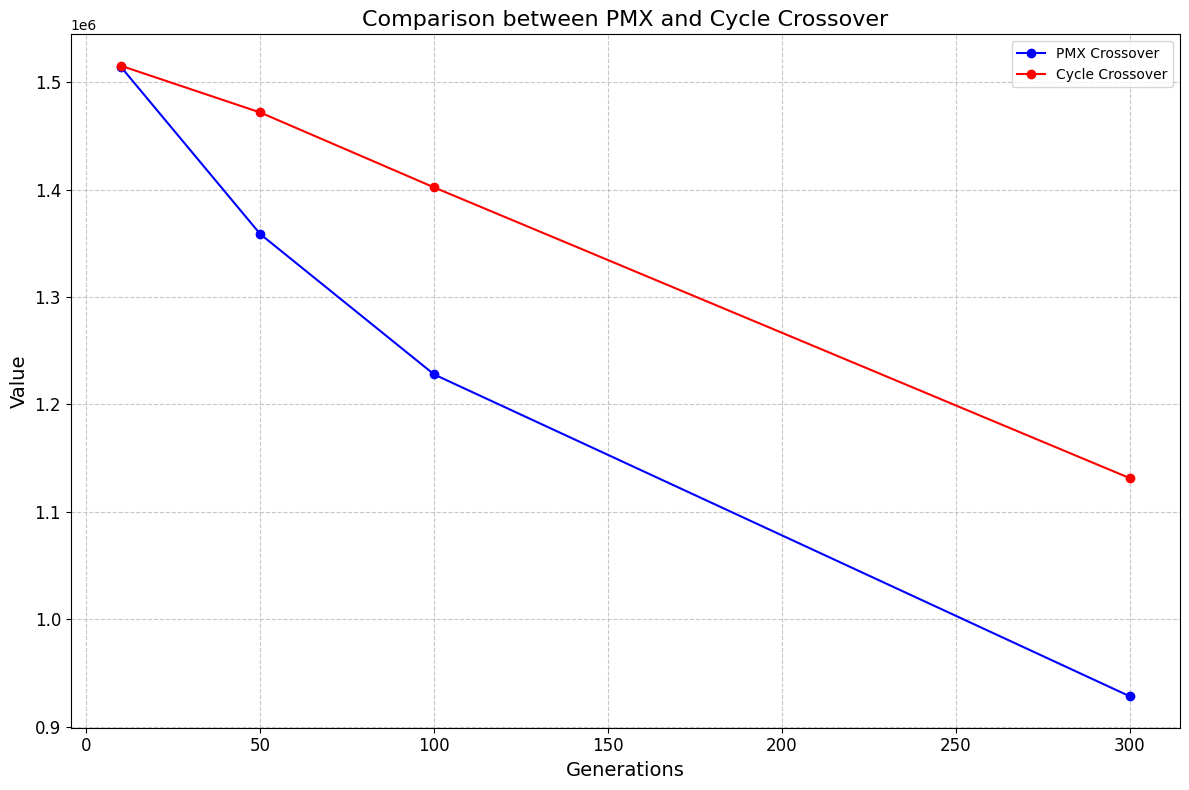

In [482]:
cities = load_tsp_data("data/tsp/uy734.tsp")
plot_comparison_pmx_cycle(cities, 50, 0.3, [10, 50, 100, 300])

| Generations | PMX Value   | PMX Time (s) | Cycle Value  | Cycle Time (s) |
|-------------|-------------|--------------|--------------|----------------|
| 10          | 1513836.50  | 3.36         | 1515098.39   | 3.41           |
| 50          | 1358529.98  | 16.28        | 1471693.84   | 16.31          |
| 100         | 1227947.00  | 32.24        | 1401984.39   | 32.46          |
| 300         | 928559.72   | 96.79        | 1131548.37   | 101.23         |

# Results and conclusions for `uy734.tsp` dataset
## Plot:
   - The algorithm gets better as the number of generations increases.
   - PMX crossover method outperforms the Cycle crossover method again.
## Table:
   - Computation time is quite high for this dataset, hard to get to great solutions.


| Crossover | Population Size | Mutation Rate | Value | Computation Time (s) |
|-----------|-----------------|---------------|-------|----------------------|
| PMX       | 5           | 0         | 1618588.48 | 1.81 |
| Cycle     | 5           | 0         | 1595304.59 | 1.66 |
| PMX       | 5           | 0.25         | 1567836.97 | 1.66 |
| Cycle     | 5           | 0.25         | 1549961.03 | 1.65 |
| PMX       | 5           | 0.5         | 1552848.26 | 1.67 |
| Cycle     | 5           | 0.5         | 1550961.69 | 1.72 |
| PMX       | 5           | 0.75         | 1482060.16 | 1.68 |
| Cycle     | 5           | 0.75         | 1504141.29 | 1.64 |
| PMX       | 5           | 1         | 1476861.42 | 1.69 |
| Cycle     | 5           | 1         | 1518090.07 | 1.66 |
| PMX       | 15           | 0         | 1513945.57 | 4.88 |
| Cycle     | 15           | 0         | 1574170.75 | 4.77 |
| PMX       | 15           | 0.25         | 1407821.29 | 4.99 |
| Cycle     | 15           | 0.25       

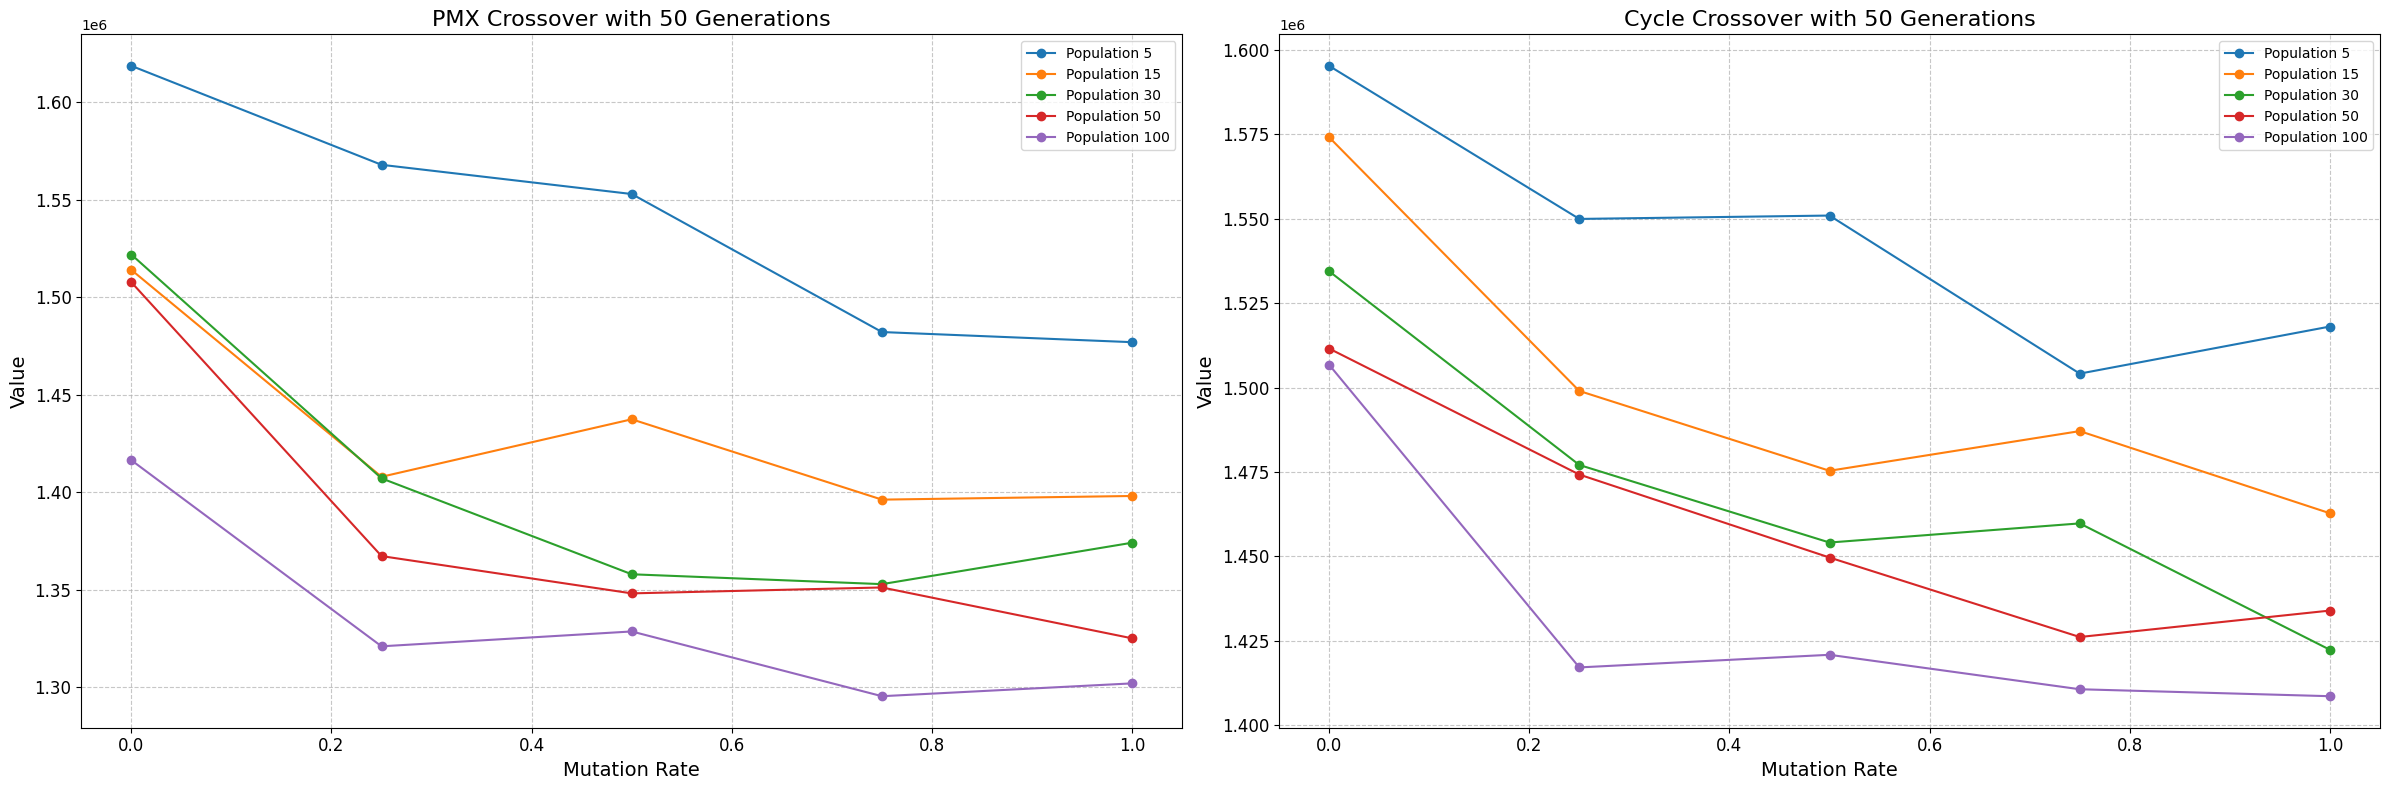

In [483]:
plot_comparison_pmx_cycle_diff_mutation(cities, 50, [0, 0.25, 0.5, 0.75, 1], [5, 15, 30, 50, 100])

| Population Size | Mutation Rate | PMX Value | PMX Time (s) | Cycle Value | Cycle Time (s) |
|-----------------|---------------|-----------|--------------|-------------|----------------|
| 5               | 0             | 1618588.48 | 1.81         | 1595304.59  | 1.66           |
| 5               | 0.25          | 1567836.97 | 1.66         | 1549961.03  | 1.65           |
| 5               | 0.5           | 1552848.26 | 1.67         | 1550961.69  | 1.72           |
| 5               | 0.75          | 1482060.16 | 1.68         | 1504141.29  | 1.64           |
| 5               | 1             | 1476861.42 | 1.69         | 1518090.07  | 1.66           |
| 15              | 0             | 1513945.57 | 4.88         | 1574170.75  | 4.77           |
| 15              | 0.25          | 1407821.29 | 4.99         | 1499007.74  | 4.85           |
| 15              | 0.5           | 1437317.02 | 4.91         | 1475364.96  | 4.89           |
| 15              | 0.75          | 1396101.77 | 5.13         | 1487113.26  | 4.88           |
| 15              | 1             | 1397976.94 | 5.26         | 1462774.18  | 4.93           |
| 30              | 0             | 1521815.34 | 9.98         | 1534478.98  | 9.76           |
| 30              | 0.25          | 1407021.21 | 9.75         | 1477084.86  | 9.80           |
| 30              | 0.5           | 1357818.03 | 9.72         | 1454109.53  | 9.81           |
| 30              | 0.75          | 1352761.25 | 9.70         | 1459776.47  | 10.02          |
| 30              | 1             | 1374013.13 | 10.07        | 1422336.79  | 10.18          |
| 50              | 0             | 1507615.14 | 18.18        | 1511577.45  | 16.27          |
| 50              | 0.25          | 1367146.31 | 17.32        | 1474244.47  | 17.49          |
| 50              | 0.5           | 1348020.91 | 16.96        | 1449667.88  | 18.30          |
| 50              | 0.75          | 1351054.56 | 19.64        | 1426122.24  | 16.66          |
| 50              | 1             | 1324957.27 | 16.30        | 1433957.23  | 16.84          |
| 100             | 0             | 1416326.7  | 33.52        | 1506787.23  | 34.58          |
| 100             | 0.25          | 1320869.32 | 33.59        | 1417117.89  | 32.55          |
| 100             | 0.5           | 1328491.45 | 33.92        | 1420855.37  | 33.99          |
| 100             | 0.75          | 1295282.47 | 40.46        | 1410651.15  | 33.08          |
| 100             | 1             | 1301864.23 | 31.92        | 1408590.48  | 31.87          |

## Comparing tabu search with evolutionary algorithm for TSP problem


### Tabu Search

In [4]:
def get_neighbours_2opt(tour: list[int]) -> list[tuple[int, int]]:
    """
    Generate neighbors using the 2-opt move.
    Input:
        tour: list of city indices representing the current tour
    Output:
        list: list of tuples representing the swap indices
    """
    neighbours = []
    n = len(tour)

    for i in range(n - 1):
        for j in range(i + 2, n):  # Ensure non-adjacent swaps
            neighbours.append((i, j))  # Just return the swap indices

    return neighbours

def tabu_search_random_tsp(cities: list[tuple[float, float]], max_tries: int, max_iter: int, tabu_size: int) -> tuple[list[int], float]:
    """
    Perform Tabu Search for the Traveling Salesman Problem using 2-opt moves and random starts.
    Input:
        cities: list of tuples, each tuple contains (x, y) coordinates of a city
        max_tries: int, number of independent runs
        max_iter: int, maximum iterations per run
        tabu_size: int, size of the tabu list
    Output:
        tuple: best tour found and its total distance
    """
    best_global_tour = None
    best_global_distance = float('inf')


    for _ in range(max_tries):

        current_tour = random_tour(cities)
        best_local_tour = current_tour
        best_local_distance = fitness_tsp(current_tour, cities)
        tabu_list = set()  # Store tabu moves as swapped edges

        for _ in range(max_iter):
            best_neighbour = None
            best_neighbour_distance = float('inf')
            best_move = None

            # Step 1: Generate 2-opt neighbors (only the moves)
            moves = get_neighbours_2opt(current_tour)

            # Step 2: Select the best move from T
            for move in moves:
                i, j = move

                # Apply the 2-opt move: reverse the segment between i and j
                new_tour = current_tour[:i] + current_tour[i:j][::-1] + current_tour[j:]
                new_distance = fitness_tsp(new_tour, cities)

                # Aspiration criterion: allow tabu move if it's the best so far
                if move in tabu_list and new_distance >= best_local_distance:
                    continue

                if new_distance < best_neighbour_distance:
                    best_neighbour = new_tour
                    best_neighbour_distance = new_distance
                    best_move = move

            # Step 3: Move to the best non-tabu neighbor
            if best_neighbour:
                current_tour = best_neighbour
                current_distance = best_neighbour_distance

                # Step 4: Update global best if improved
                if current_distance < best_local_distance:
                    best_local_tour = current_tour[:]
                    best_local_distance = current_distance

                # Step 5: Update Tabu List (store the move)
                tabu_list.add(best_move)
                if len(tabu_list) > tabu_size:
                    tabu_list.pop()  # Maintain fixed tabu size

        if best_local_distance < best_global_distance:
            best_global_tour = best_local_tour
            best_global_distance = best_local_distance

    return best_global_tour, best_global_distance


In [25]:
def compare_algorithms(cities, generations, iterations, pop_size, mutation_rate, crossover_operator, tabu_size, max_tries):
    tabu_results = []
    ea_results = []

    print("| Iter./Gens. | Algorithm | Total Distance | Computation Time (s) |")
    print("|-------------|-----------|----------------|----------------------|")

    for gen, it in zip(generations, iterations):
        # Tabu Search
        start_time = time.time()
        _, total_distance = tabu_search_random_tsp(cities, max_tries, it, tabu_size)
        computation_time = time.time() - start_time
        tabu_results.append((computation_time, total_distance))
        print(f"| {it:<10} | Tabu Search   | {total_distance:<14} | {computation_time:<20.2f} |")

        # Evolutionary Algorithm
        start_time = time.time()
        _, total_distance = evolutionary_algorithm_tsp(cities, pop_size, mutation_rate, gen, crossover_operator)
        computation_time = time.time() - start_time
        ea_results.append((computation_time, total_distance))
        print(f"| {gen:<11}  | Evolutionary Algorithm | {total_distance:<14} | {computation_time:<20.2f} |")

    # Extract data for plotting
    tabu_times, tabu_values = zip(*tabu_results)
    ea_times, ea_values = zip(*ea_results)

    # Plot Value vs. Computation Time
    plt.figure(figsize=(10, 6))
    plt.plot(tabu_times, tabu_values, 'ro-', label="Tabu Search")  # Red line with circles
    plt.plot(ea_times, ea_values, 'bs-', label="Evolutionary Algorithm")  # Blue line with squares

    plt.xlabel("Computation Time (s)")
    plt.ylabel("Best Distance Found")
    plt.title("Tabu Search vs. Evolutionary Algorithm: Performance Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


| Iter./Gens. | Algorithm | Total Distance | Computation Time (s) |
|-------------|-----------|----------------|----------------------|
| 1          | Tabu Search   | 162761.39      | 1.18                 |
| 100          | Evolutionary Algorithm | 66144.96       | 3.41                 |
| 10         | Tabu Search   | 118319.66      | 11.54                |
| 500          | Evolutionary Algorithm | 29280.92       | 17.61                |
| 25         | Tabu Search   | 65693.22       | 30.36                |
| 1000         | Evolutionary Algorithm | 26333.6        | 38.16                |
| 50         | Tabu Search   | 35041.63       | 65.49                |
| 3000         | Evolutionary Algorithm | 23938.4        | 117.28               |
| 100        | Tabu Search   | 23934.52       | 125.98               |
| 5000         | Evolutionary Algorithm | 23249.3        | 182.37               |


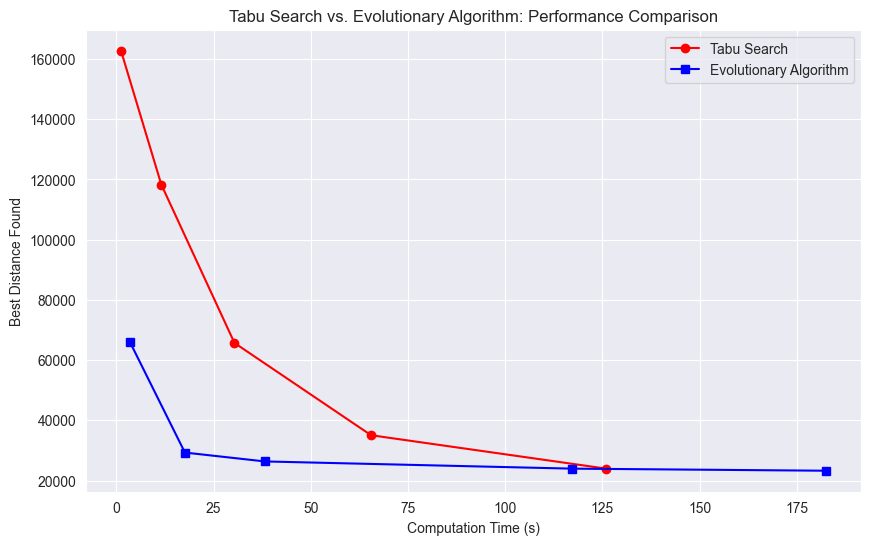

In [27]:
cities = load_tsp_data("data/tsp/kroE100.tsp")
compare_algorithms(cities, [100, 500, 1000, 3000, 5000], [1, 10, 25, 50, 100], 40, 0.75, 'pmx', 15, 2)

# Results of comparison on `kroE100.tsp` dataset

## Plot:
- The **Evolutionary Algorithm (EA)** improves significantly as generations increase.
- **Tabu Search** performs well for lower iterations but is slower at high iterations.

## Table:
- Computation time increases significantly for both approaches as iterations/generations increase.
- **Evolutionary Algorithm** consistently finds better solutions, but at a higher computational cost for large generations.
- **Tabu Search** struggles at lower iterations but catches up at higher iterations.

| Iter./Gens. | Algorithm              | Total Distance | Computation Time (s) |
|-------------|------------------------|----------------|----------------------|
| 1           | Tabu Search             | 162761.39      | 1.18                 |
| 100         | Evolutionary Algorithm  | 66144.96       | 3.41                 |
| 10          | Tabu Search             | 118319.66      | 11.54                |
| 500         | Evolutionary Algorithm  | 29280.92       | 17.61                |
| 25          | Tabu Search             | 65693.22       | 30.36                |
| 1000        | Evolutionary Algorithm  | 26333.6        | 38.16                |
| 50          | Tabu Search             | 35041.63       | 65.49                |
| 3000        | Evolutionary Algorithm  | 23938.4        | 117.28               |
| 100         | Tabu Search             | 23934.52       | 125.98               |
| 5000        | Evolutionary Algorithm  | 23249.3        | 182.37               |

## Key Takeaways:
- **EA finds the best solution overall** but requires significantly more computation time.
- **Tabu Search can be competitive** but needs more iterations to perform well.
- For **quick approximations**, Tabu Search is preferable, especially for smaller datasets.
- For **optimal solutions**, EA with **PMX crossover** is the best approach.
- Tabu Search is heavily dependent on initial random solution generated, while EA is more robust.
